Just a simple XGB starter. Huge thanks to @the1owl for [the kernel](https://www.kaggle.com/the1owl/surprise-me/code) with all of the data wrangling.

In [745]:
import torch
from torch import optim, nn, FloatTensor as FT
import torch.nn.parallel
import torch.utils.data
import torch.nn.functional as F
from torch.backends import cudnn
from torchvision import datasets, transforms, utils as vutils
from torch.autograd import Variable
from models import EmbedModel, ContModel, RegModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import pdb
#import xgboost as xgb NEED TO INSTALL
import gc
from sklearn_pandas import DataFrameMapper
SEED = 123
np.random.seed(SEED)
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [746]:
# Data wrangling brought to you by the1owl
# https://www.kaggle.com/the1owl/surprise-me

data = {
    'tra': pd.read_csv('input/air_visit_data.csv'),
    'as': pd.read_csv('input/air_store_info.csv'),
    'hs': pd.read_csv('input/hpg_store_info.csv'),
    'ar': pd.read_csv('input/air_reserve.csv'),
    'hr': pd.read_csv('input/hpg_reserve.csv'),
    'id': pd.read_csv('input/store_id_relation.csv'),
    'tes': pd.read_csv('input/sample_submission.csv'),
    'hol': pd.read_csv('input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }


In [747]:
data['hr'].shape, data['id'].shape

((2000320, 4), (150, 2))

In [748]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'].shape

(28183, 5)

In [749]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


In [750]:
#AGGREGATE RESERVATION DATA ACROSS STORE/DATE COMBINATIONS
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
    print(data[df].head())


           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


In [751]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [752]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [753]:
#DATE PARSING AND SPLITTING OF ID IN TEST SET
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month -1 #-1 so embeddings work 
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month -1
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date


In [754]:
print(data['tra'].head())
print(data['tes'].head())

           air_store_id  visit_date  visitors  dow  year  month
0  air_ba937bf13d40fb24  2016-01-13        25    2  2016      0
1  air_ba937bf13d40fb24  2016-01-14        32    3  2016      0
2  air_ba937bf13d40fb24  2016-01-15        29    4  2016      0
3  air_ba937bf13d40fb24  2016-01-16        22    5  2016      0
4  air_ba937bf13d40fb24  2016-01-18         6    0  2016      0
                                id  visitors  visit_date  \
0  air_00a91d42b08b08d9_2017-04-23         0  2017-04-23   
1  air_00a91d42b08b08d9_2017-04-24         0  2017-04-24   
2  air_00a91d42b08b08d9_2017-04-25         0  2017-04-25   
3  air_00a91d42b08b08d9_2017-04-26         0  2017-04-26   
4  air_00a91d42b08b08d9_2017-04-27         0  2017-04-27   

           air_store_id  dow  year  month  
0  air_00a91d42b08b08d9    6  2017      3  
1  air_00a91d42b08b08d9    0  2017      3  
2  air_00a91d42b08b08d9    1  2017      3  
3  air_00a91d42b08b08d9    2  2017      3  
4  air_00a91d42b08b08d9    3  2017 

In [755]:
#CREATE UNIQUE STORES/DOW COMBOS
unique_stores = data['tes']['air_store_id'].unique() #821 unique stores
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [756]:
stores.head()

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0


In [757]:
len(data['tra'])

252108

In [758]:
#AGGREGATE INFO ACROSS STORE/DOW COMBOS
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 


In [759]:
print(len(stores))
stores.head()

5747


,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [760]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [761]:
#Label Encode Genre/Area
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
lbl_gen = preprocessing.LabelEncoder()
lbl_area = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl_gen.fit_transform(stores['air_genre_name']) + 1 #so we can fill missing with 0
stores['air_area_name'] = lbl_area.fit_transform(stores['air_area_name']) + 1 #so we can fill missing with 0
stores.air_genre_name.nunique(), stores.air_area_name.nunique()

(14, 103)

In [762]:
data['ar'].head()

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4


In [763]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [764]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol'].drop('day_of_week', axis=1, inplace=True)
#data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week']) #Not sure this is right?
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

data['tra'] = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
data['tes'] = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
train.loc[:, ['air_genre_name', 'air_area_name']] = train.loc[:, ['air_genre_name', 'air_area_name']].fillna(0) #for entity embeddings
test.loc[:, ['air_genre_name', 'air_area_name']] = test.loc[:, ['air_genre_name', 'air_area_name']].fillna(0)
train = train.fillna(-1)
test = test.fillna(-1)

In [765]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,holiday_flg,min_visitors,mean_visitors,...,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,3,0,2.0,2.000000,...,2.0,1.0,7,45,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,3,0,1.0,22.457143,...,47.0,35.0,7,45,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,3,0,1.0,24.350000,...,43.0,40.0,7,45,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,3,0,15.0,28.125000,...,52.0,40.0,7,45,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,3,0,15.0,29.868421,...,47.0,38.0,7,45,35.694003,139.753595,-1.0,-1.0,-1.0,-1.0


In [766]:
# XGB starter template borrowed from @anokas
# https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655
##NOT SURE ABOUT THIS, ESPECIALLY FOR LATT AND LONG
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
                
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

Binding to float32


In [767]:
#SHOULDN'T DROP AIR STORE ID. SHOULD LABEL ENCODE OF SOMETHING?
train.sort_values('visit_date', inplace=True)
train = train.drop(['air_store_id','visit_date'], axis=1) 

In [768]:
'''# Create training / validation split
split = 200000
#x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

tr, val = train[:split], train[split:]
'''

'# Create training / validation split\nsplit = 200000\n#x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]\n\ntr, val = train[:split], train[split:]\n'

In [769]:
def rmsle(pred, act):
    assert len(pred) == len(act)
    return np.sqrt(np.mean(np.power(np.log1p(pred)-act, 2)))

### Entity Embedding

In [770]:
to_embed = ['dow', 'year', 'month', 'holiday_flg', 'air_genre_name', 'air_area_name']
cont_cols = ['min_visitors',
       'mean_visitors', 'median_visitors', 'max_visitors',
       'count_observations', 'latitude',
       'longitude', 'reserve_datetime_diff_x', 'reserve_visitors_x',
       'reserve_datetime_diff_y', 'reserve_visitors_y']

to_embed = [ 'holiday_flg',]
cont_cols = [
       'mean_visitors', 'median_visitors']

In [771]:
embed_info = list(zip(to_embed, train[to_embed].nunique().values, np.ones(len(to_embed)) * 2))
embed_info

[('holiday_flg', 2, 2.0)]

In [772]:
df_map = [('year', LabelEncoder())] + [([o], StandardScaler()) for o in cont_cols]
mapper = DataFrameMapper(df_map, input_df=True, df_out=True, default=None)

In [773]:
mapper_fit = mapper.fit(train)

In [774]:
train = mapper_fit.transform(train)

In [775]:
'''
#NEED TO START YEAR VALUES AT 0 FOR EMBEDDINGS
lbl_yr = preprocessing.LabelEncoder()
train.loc[:, 'year'] =  lbl_yr.fit_transform(train.loc[:,'year'])

#NORMALIZE CONTINUOUS COLUMNS
sc = preprocessing.StandardScaler().fit(train[cont_cols].values)
train.loc[:, cont_cols] = sc.transform(train[cont_cols])
'''

"\n#NEED TO START YEAR VALUES AT 0 FOR EMBEDDINGS\nlbl_yr = preprocessing.LabelEncoder()\ntrain.loc[:, 'year'] =  lbl_yr.fit_transform(train.loc[:,'year'])\n\n#NORMALIZE CONTINUOUS COLUMNS\nsc = preprocessing.StandardScaler().fit(train[cont_cols].values)\ntrain.loc[:, cont_cols] = sc.transform(train[cont_cols])\n"

In [776]:
train.head()

,year,mean_visitors,median_visitors,visitors,dow,month,holiday_flg,min_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
189299,0.0,-0.824213,-0.757776,19.0,4.0,0.0,1.0,2.0,20.0,68.0,3.0,4.0,33.581940,130.348434,-1.0,-1.0,-1.0,-1.0
200675,0.0,1.633839,1.745334,64.0,4.0,0.0,1.0,20.0,64.0,68.0,8.0,78.0,35.693840,139.703552,-1.0,-1.0,-1.0,-1.0
213541,0.0,0.738021,0.337335,102.0,4.0,0.0,1.0,9.0,139.0,69.0,3.0,74.0,35.669289,139.707062,-1.0,-1.0,-1.0,-1.0
161915,0.0,0.364812,0.337335,55.0,4.0,0.0,1.0,9.0,55.0,69.0,8.0,32.0,34.799767,135.360077,-1.0,-1.0,-1.0,-1.0
142213,0.0,0.061436,-0.131999,42.0,4.0,0.0,1.0,5.0,69.0,69.0,13.0,80.0,35.699566,139.636444,-1.0,-1.0,-1.0,-1.0


In [777]:
train.loc[:, 'visitors'] = train.visitors.apply(np.log1p)

# Create training / validation split
split = 200000
#x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
tr, val = train[:split], train[split:]
#y_tr = tr['visitors']; y_val = val['visitors']
#x_tr = tr.drop('visitors', axis=1); x_val = val.drop('visitors', axis=1)

tr.shape, val.shape

((200000, 18), (52108, 18))

In [778]:
def to_var(data, volatile=False):
    if torch.cuda.is_available():
        return Variable(torch.Tensor(data), volatile=volatile).cuda()
    else:
        return Variable(torch.Tensor(data), volatile=volatile)

In [783]:
cont_mod_out_size = 32
BATCH_SIZE = 64
embed_out_size = int(sum([info[2] for info in embed_info]))
emb_mod = EmbedModel(embed_info, do=.95)
cont_mod = ContModel(len(cont_cols), cont_mod_out_size, do=.95)
reg_mod = RegModel(cont_mod_out_size + embed_out_size, h1_size=64, do=.95)
crit = torch.nn.MSELoss()
LR = 0.001
params = list(emb_mod.parameters()) + list(cont_mod.parameters()) + list(reg_mod.parameters())
optimizer = torch.optim.Adam(params, lr=LR)
PRINT_EVERY = 50
EPOCHS = 2

In [784]:
print(emb_mod.children)
print(cont_mod.children)
print(reg_mod.children)
params = sum([np.prod(p.size()) for m in [emb_mod, cont_mod, reg_mod] for p in m.parameters()])
print(params)

<bound method Module.children of EmbedModel (
  (embed_0): Embedding(2, 2)
  (do): Dropout (p = 0.95)
)>
<bound method Module.children of ContModel (
  (linear): Linear (2 -> 32)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
  (do): Dropout (p = 0.95)
)>
<bound method Module.children of RegModel (
  (h1): Linear (34 -> 64)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
  (do1): Dropout (p = 0.95)
  (out): Linear (64 -> 1)
)>
2597


In [785]:
def sanity(batch):
    print(batch.index)
    
def avg_loss(loss, i):
    return torch.sqrt(loss / (i +1)).data[0]

In [786]:
##MAIN TRAINING LOOP
emb_mod.train(); cont_mod.train(); reg_mod.train();
losses = []
for epoch in range(EPOCHS):
    num_steps = (len(tr) // BATCH_SIZE) - 1
    run_loss = 0.0
    tr_samp = tr.sample(frac=1, random_state=SEED)
    for i in range(num_steps):
        optimizer.zero_grad()
        batch = tr_samp.iloc[i:i+BATCH_SIZE, :]
        #pdb.set_trace()
        #sanity(batch)
        batch_to_embed = to_var(batch.loc[:, to_embed].values).type(torch.LongTensor)
        batch_cont = to_var(batch.loc[:, cont_cols].values)
        batch_y = to_var(batch.loc[:, 'visitors'].values)
        batch_embeds = emb_mod(batch_to_embed)
        cont_out = cont_mod(batch_cont)
        reg_inp = torch.cat([batch_embeds, cont_out], 1)
        final_out = reg_mod(reg_inp) 
        loss = crit(final_out, batch_y)
        loss.backward()
        optimizer.step()
        run_loss += loss
        if (i+1) % PRINT_EVERY == 0:
            val_loss = get_pred_loss(val.sample(n=20000))
            print('step {} tr loss: {}, val loss: {}'.format(i, avg_loss(run_loss, i), val_loss))
            run_loss = 0.0
    print('Epoch {} last loss {}'.format(epoch, avg_loss(run_loss, i)))


step 49 tr loss: 3.11667537689209, val loss: 2.780055284500122
step 99 tr loss: 1.6866835355758667, val loss: 2.244260549545288
step 149 tr loss: 1.0521308183670044, val loss: 1.3621350526809692
step 199 tr loss: 0.42364636063575745, val loss: 0.9793781638145447
step 249 tr loss: 0.2374269664287567, val loss: 0.9944427609443665
step 299 tr loss: 0.21383020281791687, val loss: 1.0111600160598755
step 349 tr loss: 0.19423909485340118, val loss: 1.009087085723877
step 399 tr loss: 0.19410251080989838, val loss: 1.0396088361740112


KeyboardInterrupt: 

In [620]:
def get_preds(df, batch_size=4):
    outs = []
    num_steps = len(df) // batch_size
    emb_mod.eval(); cont_mod.eval(); reg_mod.eval();
    for i in range(num_steps):
        batch = val.iloc[i:i+batch_size, :]
        #pdb.set_trace()
        #sanity(batch)
        batch_to_embed = to_var(batch.loc[:, to_embed].values, volatile=True).type(torch.LongTensor)
        batch_cont = to_var(batch.loc[:, cont_cols].values, volatile=True)
        batch_embeds = emb_mod(batch_to_embed)
        cont_out = cont_mod(batch_cont)
        reg_inp = torch.cat([batch_embeds, cont_out], 1)
        outs.append(reg_mod(reg_inp))
    return torch.cat(outs)

In [633]:
def get_pred_loss(df, batch_size=4):
    preds = get_preds(df)
    y = to_var(torch.Tensor(df.visitors.values)); 
    preds = torch.cat(preds).squeeze(); 
    return torch.sqrt(crit(preds, y)).data[0]

In [629]:
val_preds = get_preds(val)

val_y = to_var(torch.Tensor(val.visitors.values)); val_y.size()
val_preds = torch.cat(val_preds).squeeze(); val_preds.size()

In [631]:
val_preds.data.numpy().max()

4.8982573

In [632]:
torch.sqrt(crit(val_preds, val_y)).data[0]

0.8897311687469482

In [504]:
test_ids = test.id
test = test.drop(['air_store_id','visit_date', 'day_of_week', 'id'], axis=1) 
test.head()

,visitors,dow,year,month,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,0,6,2017,3,0,2.0,2.000000,2.0,2.0,1.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,0,0,2017,3,0,1.0,22.457144,19.0,47.0,35.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,0,1,2017,3,0,1.0,24.350000,24.5,43.0,40.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,0,2,2017,3,0,15.0,28.125000,28.0,52.0,40.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,0,3,2017,3,0,15.0,29.868422,30.0,47.0,38.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


In [505]:
test.head()

,visitors,dow,year,month,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,0,6,2017,3,0,2.0,2.000000,2.0,2.0,1.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,0,0,2017,3,0,1.0,22.457144,19.0,47.0,35.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,0,1,2017,3,0,1.0,24.350000,24.5,43.0,40.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,0,2,2017,3,0,15.0,28.125000,28.0,52.0,40.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,0,3,2017,3,0,15.0,29.868422,30.0,47.0,38.0,7,45,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


In [506]:
test_fit = mapper_fit.transform(test)

In [507]:
test_fit.head()

,year,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y,visitors,dow,month,holiday_flg,air_genre_name,air_area_name
0,1.0,-0.519280,-1.486354,-1.383554,-1.277587,-3.351028,0.091249,0.281255,-0.016028,-0.221856,-0.13069,-0.167472,0.0,6.0,3.0,0.0,7.0,45.0
1,1.0,-0.676391,0.129601,-0.053776,-0.062345,-1.027262,0.091249,0.281255,-0.016028,-0.221856,-0.13069,-0.167472,0.0,0.0,3.0,0.0,7.0,45.0
2,1.0,-0.676391,0.279122,0.376446,-0.170367,-0.685532,0.091249,0.281255,-0.016028,-0.221856,-0.13069,-0.167472,0.0,1.0,3.0,0.0,7.0,45.0
3,1.0,1.523167,0.577318,0.650223,0.072681,-0.685532,0.091249,0.281255,-0.016028,-0.221856,-0.13069,-0.167472,0.0,2.0,3.0,0.0,7.0,45.0
4,1.0,1.523167,0.715035,0.806668,-0.062345,-0.822224,0.091249,0.281255,-0.016028,-0.221856,-0.13069,-0.167472,0.0,3.0,3.0,0.0,7.0,45.0


In [ ]:
test_preds = get_preds(test_fit, batch_size=1)

In [510]:
test_preds.size()

torch.Size([32019, 1])

In [511]:
test_ids.shape

(32019,)

In [512]:
test_sub = pd.DataFrame(np.stack([test_ids.values, test_preds.squeeze().data.numpy()], axis=1), columns=['id', 'visitors'])

In [513]:
test_sub.loc[:, 'visitors'] = test_sub.visitors.apply(lambda x: np.expm1(x))

In [514]:
test_sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,15.347820
1,air_00a91d42b08b08d9_2017-04-24,15.446642
2,air_00a91d42b08b08d9_2017-04-25,15.411694
3,air_00a91d42b08b08d9_2017-04-26,15.460737
4,air_00a91d42b08b08d9_2017-04-27,15.377047


In [515]:
test_sub.visitors.min()

15.198757159103103

In [516]:
test_sub.visitors.max()

17.231981210277414

In [519]:
test_sub.to_csv('subs/test_sub.csv', index=False)

### Xgboost

In [8]:
print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect()
print('Training ...')

params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.04
params['max_depth'] = 7
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

del d_train, d_valid

Training ...
[0]	train-rmse:2.35534	valid-rmse:2.31562
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:1.61274	valid-rmse:1.58588
[20]	train-rmse:1.13862	valid-rmse:1.11997
[30]	train-rmse:0.847654	valid-rmse:0.834314
[40]	train-rmse:0.679493	valid-rmse:0.669518
[50]	train-rmse:0.589134	valid-rmse:0.581203
[60]	train-rmse:0.54344	valid-rmse:0.536897
[70]	train-rmse:0.521047	valid-rmse:0.515492
[80]	train-rmse:0.509896	valid-rmse:0.505626
[90]	train-rmse:0.504195	valid-rmse:0.500875
[100]	train-rmse:0.500954	valid-rmse:0.498529
[110]	train-rmse:0.498898	valid-rmse:0.497515
[120]	train-rmse:0.497411	valid-rmse:0.496977
[130]	train-rmse:0.496204	valid-rmse:0.496676
[140]	train-rmse:0.495236	valid-rmse:0.496553
[150]	train-rmse:0.494377	valid-rmse:0.49644
[160]	train-rmse:0.493569	valid-rmse:0.496363
[170]	train-rmse:0.492756	valid-rmse:0.496308
[180]	train-rmse:0.492141	valid-

In [9]:
x_test = test.drop(['id','air_store_id','visit_date','visitors'], axis=1)
d_test = xgb.DMatrix(x_test)

del x_test; gc.collect()

21

In [10]:
print('Predicting on test ...')

p_test = clf.predict(d_test)

del d_test; gc.collect()

Predicting on test ...


0

In [11]:
np.expm1(p_test)

array([  1.97033298,  17.76589584,  21.62026978, ...,   3.60183239,
         3.84982514,   3.8631916 ], dtype=float32)

In [12]:
test['visitors'] = np.expm1(p_test)

test[['id','visitors']].to_csv('xgb_submission.csv', index=False, float_format='%.3f')

### Random Forest

In [729]:
def testRf(rf):
    x_train = tr.loc[:, to_embed + cont_cols]; x_val = val.loc[:, to_embed + cont_cols]; 
    y_train = tr.loc[:, 'visitors']; y_val = val.loc[:, 'visitors']
    rf.fit(x_train.values, y_train.values) #note y_train and y_valid have already been logp1 transformed
    tr_preds = rf.predict(x_train.values)
    val_preds = rf.predict(x_val.values)
    tr_rmsle = rmsle(np.expm1(tr_preds), y_train.values)
    val_rmsle = rmsle(np.expm1(val_preds), y_val.values)
    print('tr loss: {}, val loss: {}'.format(tr_rmsle, val_rmsle))
    return rf, pd.DataFrame(rf.feature_importances_, index=x_train.columns.values)

In [730]:
from sklearn.ensemble import RandomForestRegressor

tr loss: 0.3833455552888287, val loss: 0.5601344114519679


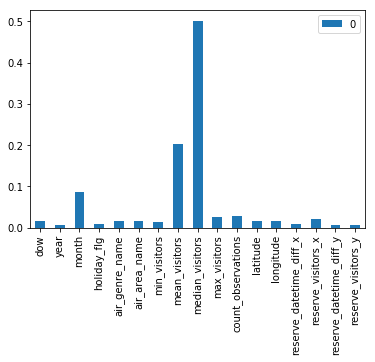

In [731]:
#BASE RF
rf = RandomForestRegressor(random_state=SEED)
rf, imp = testRf(rf)
imp.plot.bar()

tr loss: 0.5220135346256058, val loss: 0.5040344026416708


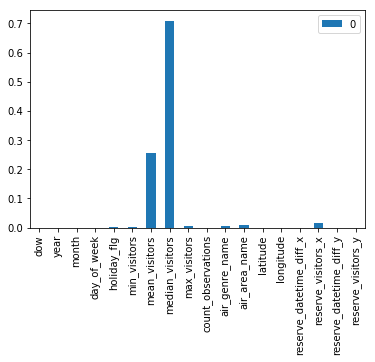

In [133]:
#OVERFITTING SO LIMIT DEPTH
rf = RandomForestRegressor(max_depth=5, random_state=SEED)
rf, imp = testRf(rf)

In [134]:
#OVERFITTING SO LIMIT DEPTH
rf = RandomForestRegressor(max_depth=8, random_state=SEED)
rf, imp = testRf(rf)

tr loss: 0.5105949961237205, val loss: 0.5049578702737085
